---
title: "
Probabilistic CUSUM for change point detection"
author: "Sarem"
date: "2022-08-04"
categories: [Time Series, Change Point Detection]
format:
  html:
    toc: true
    toc-location: left
    toc-depth: 2
    toc-title: Contents
description-meta: "CUSUM is arguably the simplest algorithm for change point detection problems as in IoT or finance applications. "
---

## Introduction

According to the famous principle of [Occam's Razor], simpler models are more likely to be close to truth than complex ones. For change point detection problems - as in IoT or finance applications - arguably the simplest one is the Cumulative Sum (CUSUM) algorithm.

Despite its simplicity though, it can nevertheless be a powerful tool. In fact, CUSUM requires only a few loose assumptions on the underlying time-series. If these assumptions are met, it is possible to prove a plethora of helpful statistical properties.

## A quick look at CUSUM
In summary, CUSUM detects shifts in the mean of a time-series that is stationary between two changepoints. Consider the following time-series:

![Example per-segment stationary time-series (blue) with change points (straight green lines). CUSUM can handle such data.](/images/probabilistic-cusum-for-change-point-detection/changepoints.png){fig-alt="Example per-segment stationary time-series (blue) with change points."}

This example is stationary between each pair of change points and thus a perfect use-case for our CUSUM algorithm. For change point detection on a non-stationary time-series like the next one, CUSUM will likely not work as intended:

![Example time-series with non-stationarity between two change points. CUSUM won't work properly with such data.
](/images/probabilistic-cusum-for-change-point-detection/changepoint_nostat.png){fig-alt="Example time-series with non-stationarity between two change points."}

While CUSUM might still be able to detect shifts from a stationary to a non-stationary segment, there is no guarantee that is does so reliably anymore.

In general, the idea behind CUSUM can roughly be summarized as follows:

> If a time-series has constant zero mean, the cumulative sum of its realizations converges to a zero-mean Normal distribution (given some relatively loose technical assumptions). Thus, if the cumulative sum diverges from a zero-mean Normal distribution, a change-point in the underlying time-series might have occurred.


We can derive this from one of the many [central limit theorems](https://en.wikipedia.org/wiki/Central_limit_theorem?ref=sarem-seitz.com) (CLTs). While each CLT has some additional requirements (e.g. independent draws and finite variance for the [Lyapunov CLT](https://en.wikipedia.org/wiki/Central_limit_theorem?ref=sarem-seitz.com#:~:text=set.%5B5%5D-,Lyapunov,-CLT%5Bedit)), chances are good that your particular time-series fulfils one of them.

In practice, we would estimate the mean of the current regime, subtract it from the time-series and calculate the cumulative sum. This only leaves the question of setting rule for when a change point has happened.

The standard CUSUM algorithm as in [Wikipedia](https://en.wikipedia.org/wiki/CUSUM?ref=sarem-seitz.com) suggests to sum the z-standardized realizations of the time-series. A change point then occurs whenever this sum exceeds a pre-defined threshold. This whole procedure is therefore an 'online' algorithm, i.e. we can use it on a live data stream.

## Some problems with the standard CUSUM algorithm
You might have already asked yourself how you should set the change point threshold values in CUSUM. After all, setting the threshold too loose will lead to undetected change points. On the other hand, narrow thresholds can easily lead to frequent false alarms.

Unfortunately, it is not easy to find clear instructions to solve this question. While a rule-of-thumb or experimenting with some setting might occasionally work, this is clearly not a reliable solution. Also, it is not feasible when we want to apply CUSUM on a large number of data streams.

Another issue concerns the level of anomaly that a given subsequence exhibits. Even if no change point happens, it might still be relevant to discover when a time-series is behaving unexpectedly.

Luckily, we can approach both challenges with a slight modification of the raw CUSUM algorithm.

## A probabilistic version of CUSUM
At this point, we will finally need some equations. First, we define the standardized observations of an arbitrary subsequence of our time-series:
$$
Z_t=\frac{X_t-\hat{\mu}_X}{\hat{\sigma}_X}
$$
The hat-notation stresses that we can only ever work with estimates of the mean and standard deviation of our series. We can calculate these values, for example, by using the first N realizations for our estimates.

If we presume that the conditions of some CLT hold for our sequence, the following holds approximately and in the limit
$$
\begin{gathered}
S_T=\sum_{t=1}^T Z_t \sim \mathcal{N}(0, T) \\
\Rightarrow \tilde{S}_T=\frac{1}{\sqrt{T}} S_T \sim \mathcal{N}(0,1)
\end{gathered}
$$
By dividing the cumulative sum by the square root of the time-frame, we get a (**theoretical**) standard Normal distribution. Thus, as long as our CLT assumptions are valid, the following holds for the standardized, cumulative sum of the realized time-series:
$$
\Phi\left(\tilde{s}_T\right) \approx P\left(\tilde{S}_T \leq \tilde{s}_T\right),
$$
where $(\Phi(\cdot)$ denotes the c.d.f. of a standard Normal distribution.

The resulting value can be interpreted as the probability of the theoretical cumulative sum being as small as the one we are observing. This is actually equivalent to the definition of [a p-value in classical hypothesis testing](https://en.wikipedia.org/wiki/P-value?ref=sarem-seitz.com).

Notice however that the above quantity currently only works in one direction, i.e. if the standardized sum is negative. In order to make this a two-sided statistic, we can ask for the probability of the standardized sum being at least as far away from the mean as our realized value. Since our sum is a scalar value, we can define 'distance from zero' simply as the absolute value and simplify:
$$
\begin{gathered}
P\left(\left|\tilde{S}_T\right| \geq\left|\tilde{s}_T\right|\right) \\
=1-P\left(-\left|\tilde{s}_T\right| \leq \tilde{S}_T \leq\left|\tilde{s}_T\right|\right) \\
=1-\left[P\left(\tilde{S}_T \leq\left|\tilde{s}_T\right|\right)-P\left(\tilde{S}_T \leq-\left|\tilde{s}_T\right|\right)\right] \\
=1-\left[P\left(\tilde{S}_T \leq\left|\tilde{s}_T\right|\right)-\left(1-P\left(\tilde{S}_T \leq\left|\tilde{s}_T\right|\right)\right)\right]\\
=2\left(1-P\left(\tilde{S}_T \leq\left|\tilde{s}_T\right|\right)\right) \\
=2\left(1-\Phi\left(\left|\tilde{s}_T\right|\right)\right)
\end{gathered}
$$
We can now use this probability instead of the raw standardized CUSUM sum for change point detection. Contrary to the original sum, this measure has a clear, probabilistic interpretation. For each new datapoint we directly obtain a measure of how extreme the respective observation is.

Once a certain threshold of 'unlikeliness' is surpassed, we mark the respective timestamp as a change point and restart the algorithm.

Roughly, the algorithm looks as follows:
0) Define $p_{\text {limit }} \in(0,1), T_{\text {warmup }}>1$
1) Collect observations $x_T$ while $T<T_{\text {warmup }}$
2) If $T=T_{\text{warmup}}$, calculate 
$$
\hat{\mu}_X=\frac{1}{T} \sum_{t=1}^T x_t, \hat{\sigma}_X=\sqrt{\frac{1}{T-1} \sum_{t=1}^T\left(x_t-\hat{\mu}_X\right)^2}
$$
3) Calculate $\tilde{s}_T$ for $T \in[1, T]$ and $p_T=2\left(1-\Phi\left(\left|\tilde{s}_T\right|\right)\right)$
4) If $p_T>p_{\text {limit }}$, detect change point and reset $T, \hat{\mu}_X, \hat{\sigma}_X$

In Python, a possible implementation could look as follows. I used PyTorch to allow for potential future extensions with autograd functionality:

In [2]:
import torch
import numpy as np
from typing import Tuple


class CusumMeanDetector():
        
    def __init__(self, t_warmup = 30, p_limit = 0.01) -> None:
        self._t_warmup = t_warmup
        self._p_limit = p_limit
        
        self._reset()
        
        

    def predict_next(self, y: torch.tensor) -> Tuple[float,bool]:
        self._update_data(y)

        if self.current_t == self._t_warmup:
            self._init_params()
        
        if self.current_t >= self._t_warmup:
            prob, is_changepoint = self._check_for_changepoint()
            if is_changepoint:
                self._reset()

            return (1-prob), is_changepoint
        
        else:
            return 0, False
            
    
    def _reset(self) -> None:
        self.current_t = torch.zeros(1)
                
        self.current_obs = []
        
        self.current_mean = None
        self.current_std = None
            
    
    def _update_data(self, y: torch.tensor) -> None:
        self.current_t += 1
        self.current_obs.append(y.reshape(1))

        
    
    def _init_params(self) -> None:
        self.current_mean = torch.mean(torch.concat(self.current_obs))
        self.current_std = torch.std(torch.concat(self.current_obs))
             
    
    def _check_for_changepoint(self) -> Tuple[float,bool]:
        standardized_sum = torch.sum(torch.concat(self.current_obs) - self.current_mean)/(self.current_std * self.current_t**0.5)
        prob = float(self._get_prob(standardized_sum).detach().numpy())
        
        return prob, prob < self._p_limit
    
    
    def _get_prob(self, y: torch.tensor) -> bool:
        p = torch.distributions.normal.Normal(0,1).cdf(torch.abs(y))
        prob = 2*(1 - p)
        
        return prob

## Probabilistic CUSUM in practice
Let us try the above algorithm on two examples. First, we use the simulated, constant mean dataset from the introduction:

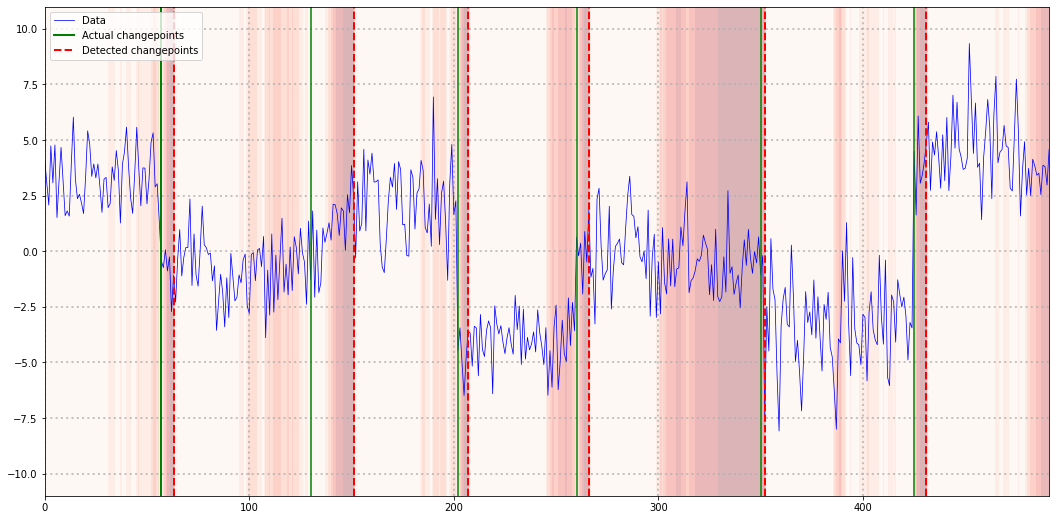

In [4]:
import matplotlib.pyplot as plt

np.random.seed(456)
torch.manual_seed(456)

segment_lengths = [np.random.randint(30,100) for _ in range(7)]


y = torch.concat([torch.normal(torch.zeros(seg_len)+np.random.uniform(-5,5),np.random.uniform()+1) for seg_len in segment_lengths])


test = CusumMeanDetector()
outs = [test.predict_next(y[i]) for i in range(len(y))]



cps = np.where(list(map(lambda x: x[1], outs)))[0]
probs = np.array(list(map(lambda x: x[0], outs)))

X, Y = np.meshgrid(np.arange(len(y)),np.linspace(-11,11))
Z = probs[X]


plt.figure(figsize=(18,9))
plt.contourf(X,Y,Z,alpha=0.3,cmap="Reds")
plt.plot(np.arange(len(y)),y.detach().numpy(),lw=0.75,label="Data",color="blue")

plt.axvline(np.cumsum(segment_lengths)[0], color="green",label="Actual changepoints",lw=2)
[plt.axvline(cp, color="green") for cp in np.cumsum(segment_lengths)[1:-1]]

plt.axvline(cps[0], color="red", linestyle="dashed",label="Detected changepoints",lw=2)
[plt.axvline(cp, color="red", linestyle="dashed",lw=2) for cp in cps[1:]]

plt.grid(alpha=0.75, linestyle="dotted",lw=2)

plt.legend()

Our modified version of CUSUM was able to detect all change points, albeit some delay in detection. However, all change points fell in regions where our probability metric already detected unusual behavior. Thus, with some fine-tuning, critical change points might have been detected even earlier.

For our second example, let us use an excerpt from the [Skoltech Anomaly Benchmark](https://www.kaggle.com/datasets/yuriykatser/skoltech-anomaly-benchmark-skab?resource=download&ref=sarem-seitz.com) dataset from Kaggle. I chose the time-series with the assumptions behind CUSUM in mind (in particular the constant mean assumption). Thus, the result should not serve as a reliable benchmark but rather as an illustrative example:

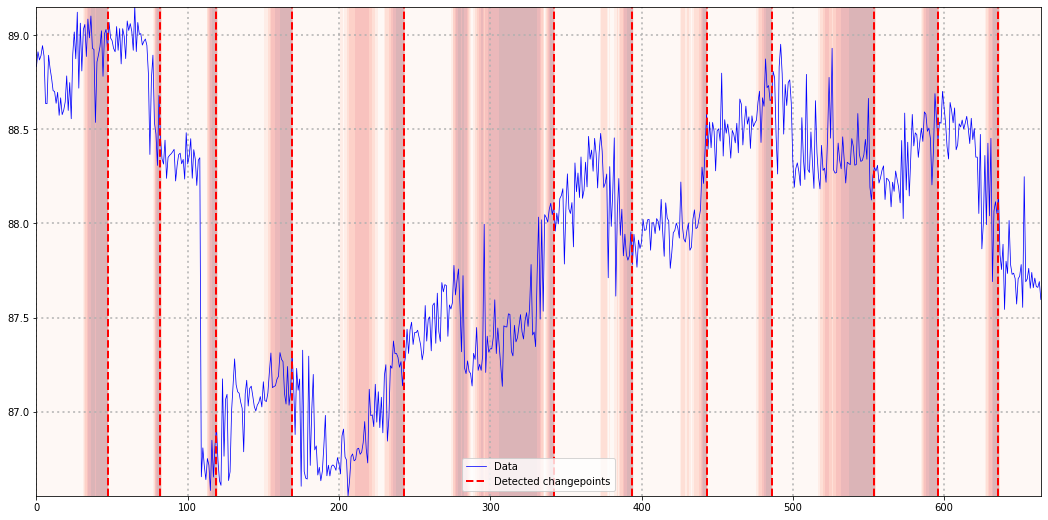

In [7]:
import pandas as pd

df = pd.read_csv("../data/SKAB/other/11.csv",sep=";")
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime")

y = torch.tensor(df.iloc[:,5].values)

test = CusumMeanDetector()
outs = [test.predict_next(y[i]) for i in range(len(y))]



cps = np.where(list(map(lambda x: x[1], outs)))[0]
probs = np.array(list(map(lambda x: x[0], outs)))

X, Y = np.meshgrid(np.arange(len(y)),np.linspace(torch.min(y).detach().numpy(),torch.max(y).detach().numpy()))
Z = probs[X]


plt.figure(figsize=(18,9))
plt.contourf(X,Y,Z,alpha=0.3,cmap="Reds")
plt.plot(np.arange(len(y)),y.detach().numpy(),lw=0.75,label="Data",color="blue")


plt.axvline(cps[0], color="red", linestyle="dashed",label="Detected changepoints",lw=2)
[plt.axvline(cp, color="red", linestyle="dashed",lw=2) for cp in cps[1:]]

plt.grid(alpha=0.75, linestyle="dotted",lw=2)

plt.legend()

While our CUSUM variant had some problems with linear trend patterns, the overall result looks reasonable. This also demonstrates the limitations of this algorithm, once the constant mean assumption is violated. Nevertheless, despite its simplicity, CUSUM appears to be a useful choice.

## Conclusion
Although CUSUM is a very simple algorithm, it can be quite powerful as long as the underlying assumptions are met. With a simple, probabilistic modification we can easily improve the standard version of CUSUM and make it more expressive and intuitive.

For more complex problems though, more sophisticated algorithms are likely necessary. One particularly useful algorithm is [Bayesian Online Changepoint Detection](https://gregorygundersen.com/blog/2019/08/13/bocd/?ref=sarem-seitz.com) which I can hopefully cover in the future.